<a href="https://colab.research.google.com/github/fernando-resende/libras-interpreter/blob/main/LibrasModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Dataset: https://github.com/fernando-resende/libras-interpreter/archive/refs/heads/main.zip

DS_SOURCE = "https://github.com/fernando-resende/libras-interpreter/archive/refs/heads/main.zip"
EXTRACTION_PATH = "/tmp/libras-ds/"
DS_PATH = EXTRACTION_PATH + "libras-interpreter-main/data/"
DS_FILE = "/tmp/libras-ds.zip"

print('Downloading dataset...')
!wget --no-check-certificate {DS_SOURCE} -O {DS_FILE}
print('Finished')

--2022-11-24 10:16:59--  https://github.com/fernando-resende/libras-interpreter/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fernando-resende/libras-interpreter/zip/refs/heads/main [following]
--2022-11-24 10:16:59--  https://codeload.github.com/fernando-resende/libras-interpreter/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/libras-ds.zip’

/tmp/libras-ds.zip      [    <=>             ] 182.78M  25.1MB/s    in 7.6s    

2022-11-24 10:17:07 (24.1 MB/s) - ‘/tmp/libras-ds.zip’ saved [191661402]

Finished


In [3]:
print('Extracting files...')
zip_ref = zipfile.ZipFile(DS_FILE, 'r') #Opens the zip file in read mode
zip_ref.extractall(EXTRACTION_PATH) #Extracts the files into the /tmp folder
zip_ref.close()
print('Finished')

Extracting files...
Finished


In [4]:
count_ds_files = sum(len(files) for root, dirs, files in os.walk(DS_PATH))
print(f'Folders in {DS_PATH}: {os.listdir(DS_PATH)}')
print(f'Total folders in {DS_PATH}: {len(os.listdir(DS_PATH))}')
print(f'Total files in {DS_PATH}: {count_ds_files}')

Folders in /tmp/libras-ds/libras-interpreter-main/data/: ['B', 'O', 'K', 'Y', 'U', 'T', 'P', 'S', 'F', 'C', 'E', 'D', 'R', 'V', 'Q', 'H', 'L', 'W', 'M', 'A', 'G', 'N', 'I']
Total folders in /tmp/libras-ds/libras-interpreter-main/data/: 23
Total files in /tmp/libras-ds/libras-interpreter-main/data/: 6900


In [9]:
BATCH_SIZE = 230  # Number of training examples to process before updating our models variables
IMG_SHAPE  = (224, 224) #Images's shape
SEED = 157
EPOCHS = 10

# train_image_generator      = ImageDataGenerator(rescale=1./255)
# validation_image_generator = ImageDataGenerator(rescale=1./255)

train_ds = tf.keras.utils.image_dataset_from_directory(
  DS_PATH,
  validation_split=0.2,
  subset="training",
  color_mode="rgb",
  seed=SEED,
  image_size=IMG_SHAPE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DS_PATH,
  validation_split=0.2,
  subset="validation",
  color_mode="rgb",
  seed=SEED,
  image_size=IMG_SHAPE,
  batch_size=BATCH_SIZE)

NUM_CLASSES = len(train_ds.class_names)

Found 6900 files belonging to 23 classes.
Using 5520 files for training.
Found 6900 files belonging to 23 classes.
Using 1380 files for validation.


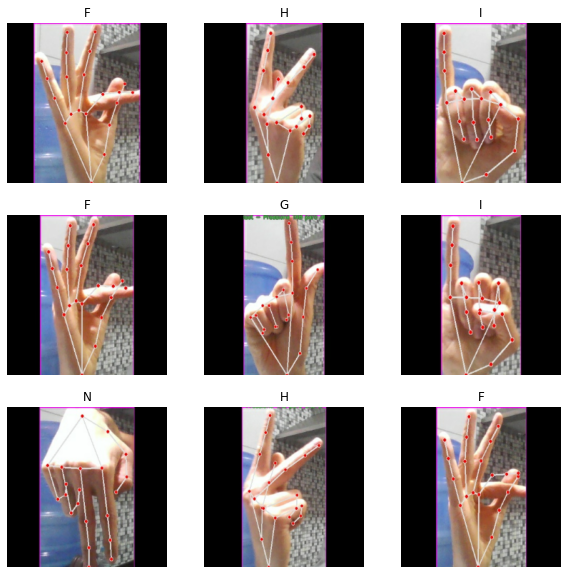

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [11]:
# normalization
normalization_layer = tf.keras.layers.Rescaling(1./127, offset=-1)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds.element_spec[0].shape

TensorShape([None, 224, 224, 3])

In [14]:
model = tf.keras.Sequential([
  #tf.keras.layers.Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  #tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.build(train_ds.element_spec[0].shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [15]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/10
24/24 [==============================] - 25s 456ms/step - loss: 1.1609 - accuracy: 0.6716 - val_loss: 0.0539 - val_accuracy: 0.9826
Epoch 2/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0486 - accuracy: 0.9857 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 9.4121e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 7s 307ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 3.5749e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 7s 309ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 9.5448e-04 - val_accuracy: 0.9993
Epoch 6/10
24/24 [==============================] - 7s 310ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 5.8303e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 7s 312ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 1.4862e-05 - val_ac

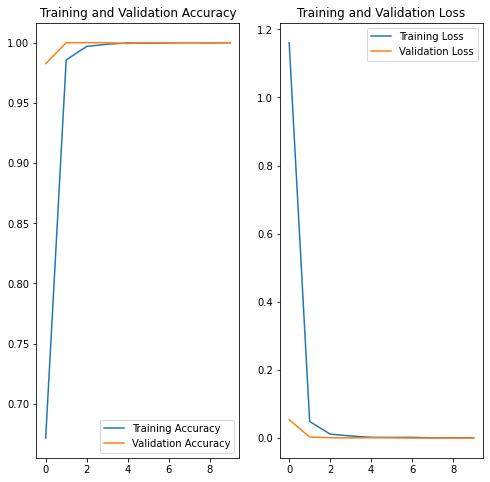

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

In [17]:
model_file_name = 'keras_model_own.h5'
model_path = f'./{model_file_name}'
model.save(model_path)
print(f'Size of {model_file_name}: {round((os.stat(model_path).st_size / 1024) / 1024, 2)} MB')

Size of keras_model_own.h5: 63.79 MB


In [18]:
model.save_weights('./keras_model_own_weights')

In [19]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [20]:
model.predict(val_ds)

6/6 [==============================] - 1s 134ms/step


array([[7.40324690e-10, 3.23896501e-08, 3.09088177e-13, ...,
        5.04324837e-12, 6.75351552e-09, 7.85769887e-12],
       [2.75439529e-13, 1.26372730e-12, 9.99729779e-15, ...,
        1.37157213e-12, 4.34074651e-11, 1.30010702e-09],
       [4.54879463e-22, 5.71144663e-25, 2.81100090e-19, ...,
        1.28274045e-26, 1.06793162e-22, 1.89773014e-24],
       ...,
       [3.61529195e-10, 1.24190740e-06, 1.89596089e-10, ...,
        2.35031328e-10, 4.74806194e-10, 5.87895010e-11],
       [1.84705376e-12, 2.27424657e-09, 1.17233745e-09, ...,
        2.87036228e-10, 3.61534047e-09, 3.95621841e-10],
       [1.15346070e-08, 6.29624701e-05, 1.89208754e-06, ...,
        5.27715770e-07, 2.67266955e-06, 2.71697763e-06]], dtype=float32)